CONCLUSION: Length of time, as measured by the difference in time between last login and the time in which a user created their account, is the best indicator of whether or not a user will be an adopted user. The following notebook contains our methodology at arriving at this conclusion, as well as a basic logistic regression and random forest classifier that we used to model adoption rates. Our correlation heatmap indicated a strong correlation between length of time and user adoption (.92), and this was further confirmed by selecting the most important feature in our random forest classifier. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import seaborn as sns
import math

In [2]:
#read data
user_file = '/Users/dankang/Downloads/relax_challenge/takehome_users.csv'
#users = pd.read_json(user_file)


In [3]:
import chardet
with open(user_file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'ISO-8859-1', 'confidence': 0.7294372453287324, 'language': ''}

In [4]:
#embed the encoding
df_users = pd.read_csv(user_file,encoding='ISO-8859-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
#repeat for engagement file
engagement_file = '/Users/dankang/Downloads/relax_challenge/takehome_user_engagement.csv'
df_engagement = pd.read_csv(engagement_file, encoding='ISO-8859-1')
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
df = df_users.rename(columns={"object_id": "user_id"})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   user_id                     12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [8]:
df['creation_time'] =  pd.to_datetime(df['creation_time'], format='%Y-%m-%d %H:%M:%S.%f')

In [9]:
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'],unit='s')

In [10]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [11]:
#lets create a new feature that shows us how long a user has been on platform
df['time_active'] = df['last_session_creation_time'] - df['creation_time']
#lets use seconds active instead of days
df['time_active'] = [x.total_seconds() for x in df['time_active']]
df['time_active'] = df['time_active'].fillna(0)

In [12]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [13]:
df_engagement['time_stamp'] =  pd.to_datetime(df_engagement['time_stamp'], format='%Y-%m-%d %H:%M:%S.%f')

In [14]:
#check for nulls in the user info df
df.isnull().values.any()


True

In [15]:
#find where they are and count them
df.isnull().sum()

user_id                          0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
time_active                      0
dtype: int64

In [16]:
df_engagement.nunique()

time_stamp    207220
user_id         8823
visited            1
dtype: int64

In [17]:
#lets add a column placeholder for adopted users
df_engagement['adopted_user'] = 0

In [18]:
#lets add a week column, so then we can group by user and count their logins per week
df_engagement['week'] = df_engagement['time_stamp'].dt.isocalendar().week

In [19]:
df_adoption = df_engagement.groupby(['week', 'user_id'])['time_stamp'].count().reset_index(name="frequency")


In [20]:
df_adoption

,week,user_id,frequency
0,1,2,1
1,1,10,5
2,1,42,4
3,1,43,1
4,1,46,1
...,...,...,...
57167,52,11961,1
57168,52,11964,2
57169,52,11969,3
57170,52,11974,1


In [21]:
result = df_adoption[df_adoption.frequency >= 3]

In [22]:
user_ids = result.user_id.tolist()

In [23]:
print(user_ids)

[10, 42, 63, 69, 81, 82, 87, 146, 153, 160, 168, 197, 202, 203, 209, 230, 245, 263, 297, 310, 322, 445, 471, 483, 509, 510, 529, 535, 553, 564, 603, 605, 639, 669, 679, 680, 724, 728, 754, 772, 783, 804, 845, 882, 885, 901, 906, 912, 934, 937, 943, 980, 1017, 1018, 1027, 1055, 1061, 1072, 1094, 1099, 1128, 1129, 1155, 1196, 1202, 1280, 1320, 1339, 1343, 1345, 1350, 1357, 1368, 1407, 1411, 1421, 1434, 1464, 1472, 1476, 1479, 1485, 1507, 1576, 1617, 1624, 1665, 1693, 1709, 1730, 1754, 1769, 1781, 1783, 1786, 1811, 1821, 1822, 1836, 1865, 1879, 1885, 1941, 2002, 2011, 2013, 2033, 2042, 2074, 2078, 2080, 2103, 2113, 2159, 2171, 2193, 2246, 2253, 2270, 2271, 2286, 2289, 2300, 2316, 2324, 2333, 2339, 2390, 2406, 2425, 2447, 2474, 2490, 2502, 2519, 2539, 2548, 2557, 2566, 2568, 2571, 2604, 2620, 2622, 2647, 2658, 2672, 2723, 2727, 2739, 2744, 2771, 2809, 2832, 2881, 2889, 2895, 2915, 2939, 2979, 3017, 3028, 3032, 3039, 3066, 3067, 3087, 3093, 3112, 3113, 3137, 3139, 3160, 3175, 3180, 3185, 31

In [24]:
print(len(user_ids))

29771


In [25]:
df['adopted_user'] = df['user_id'].isin(user_ids)

In [26]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_active,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,False
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,11750400.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,False
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,86400.0,False
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,432000.0,False


Now that we have user adoption added to our master dataframe, lets convert the "invited by user id" entry to a boolean (i.e. the presence of a user id indicates that they were invited, vs a null value which indicates they werent invited) 

In [27]:
df['invited_by_user'] = ~df['invited_by_user_id'].isnull()

In [28]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_active,adopted_user,invited_by_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,False,True
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,11750400.0,True,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,False,True
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,86400.0,False,True
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,432000.0,False,True


we will drop the features that dont help us with classifying whether a user is an adopted user or not: user_id, name, email, and invited_by_user_id

In [29]:
df = df.drop(columns=['user_id', 'email', 'invited_by_user_id', 'name'])

In [30]:
df.head()

,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,time_active,adopted_user,invited_by_user
0,2014-04-22 03:53:30,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,0.0,False,True
1,2013-11-15 03:45:04,ORG_INVITE,2014-03-31 03:45:04,0,0,1,11750400.0,True,True
2,2013-03-19 23:14:52,ORG_INVITE,2013-03-19 23:14:52,0,0,94,0.0,False,True
3,2013-05-21 08:09:28,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,86400.0,False,True
4,2013-01-17 10:14:20,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,432000.0,False,True


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   creation_time               12000 non-null  datetime64[ns]
 1   creation_source             12000 non-null  object        
 2   last_session_creation_time  8823 non-null   datetime64[ns]
 3   opted_in_to_mailing_list    12000 non-null  int64         
 4   enabled_for_marketing_drip  12000 non-null  int64         
 5   org_id                      12000 non-null  int64         
 6   time_active                 12000 non-null  float64       
 7   adopted_user                12000 non-null  bool          
 8   invited_by_user             12000 non-null  bool          
dtypes: bool(2), datetime64[ns](2), float64(1), int64(3), object(1)
memory usage: 679.8+ KB


In [32]:
X = df.select_dtypes(include=[object, 'int64', bool])

In [33]:
X.columns

Index(['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'adopted_user',
       'invited_by_user'],
      dtype='object')

In [34]:
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

In [35]:
# 1. INSTANTIATE
le = preprocessing.LabelEncoder()


# 2/3. FIT AND TRANSFORM
# use df.apply() to apply le.fit_transform to all columns
X_2 = X.apply(le.fit_transform)
X_2.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited_by_user
0,0,1,0,11,0,1
1,1,0,0,1,1,1
2,1,0,0,94,0,1
3,0,0,0,1,0,1
4,0,0,0,193,0,1


In [36]:
X_2['time_active'] = df['time_active']

In [37]:
X_2.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,adopted_user,invited_by_user,time_active
0,0,1,0,11,0,1,0.0
1,1,0,0,1,1,1,11750400.0
2,1,0,0,94,0,1,0.0
3,0,0,0,1,0,1,86400.0
4,0,0,0,193,0,1,432000.0


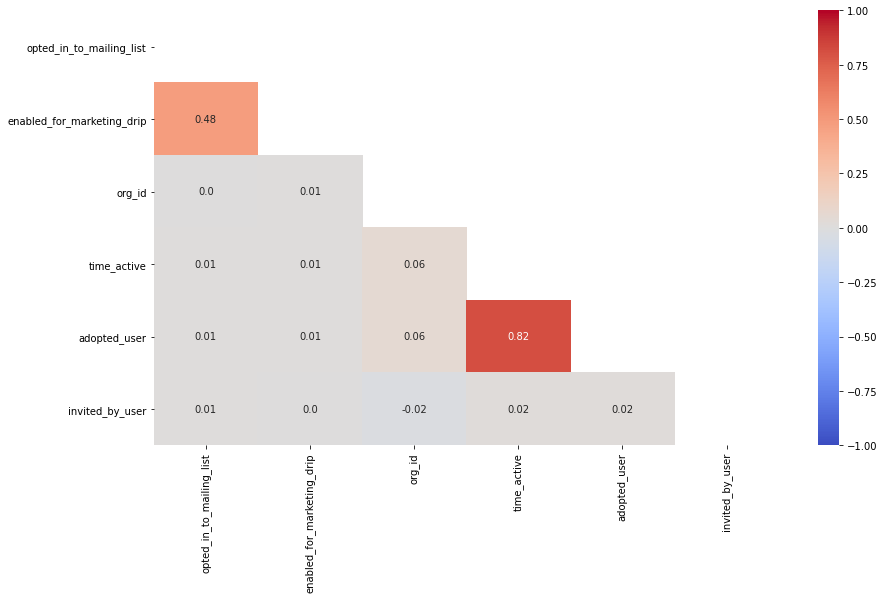

In [38]:
corrmat = df.corr()
plt.subplots(figsize=(14, 8))
mask = np.zeros(corrmat.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
sns.heatmap(corrmat.round(2), vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm', annot = True, fmt ='.2', mask = mask)
plt.show()

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into a training and test set.
X_train, X_test, y_train, y_test = train_test_split(X_2.drop('adopted_user', axis=1), 
                                              (df.adopted_user == True).values, test_size=0.2, random_state=5)

clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train, y_train)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(X_test), y_test))

0.93875


Baseline LogReg gives us 93.87% accuracy. Lets get precision recall metrics and wrap up

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

       False       0.98      0.95      0.96      2108
        True       0.70      0.88      0.78       292

    accuracy                           0.94      2400
   macro avg       0.84      0.91      0.87      2400
weighted avg       0.95      0.94      0.94      2400

confusion matrix:
[[1997  111]
 [  36  256]]


Lets try baseline random forest as well 

In [56]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.9745833333333334

In [57]:
#print out classification report and confusion matrix
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

       False       0.98      0.99      0.99      2108
        True       0.91      0.88      0.89       292

    accuracy                           0.97      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.97      0.97      0.97      2400

confusion matrix:
[[2081   27]
 [  34  258]]


In [61]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(X_2.drop('adopted_user', axis=1).columns)
feature_importance.coef.nlargest(10)

time_active                   0.906676
org_id                        0.073623
creation_source               0.010560
opted_in_to_mailing_list      0.003825
enabled_for_marketing_drip    0.003406
invited_by_user               0.001909
Name: coef, dtype: float64